# ML Health Proposal
Ventilation Prediction



Load libraries and setup environment

In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

MIMIC BigQuery access

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# MIMIC project ID
project_id = "ml-health-395010"

MIMIC IV setup (MIMIC IV version 2.2)

In [3]:
# CODE TAKEN FROM TUTORIAL 3
# accessed at: 14-08-2023

# Set up environment variables
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'


## Ventilator in ICU

Get data (label / target)

```
1. icu stay (start, end), ventilation time (start, end), mortality -- dod
2. icd9 and icd10 for respiratory condition
   icd10: J00-J99  --  https://www.icd10data.com/ICD10CM/Codes/J00-J99
   icd9 : 460-519  -- https://www.aapc.com/codes/icd9-codes-range/63/
```

In [4]:
vent_df = run_query("""

WITH resp_icd AS (
  SELECT DISTINCT
    subject_id,
    hadm_id
  FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd` icd
  WHERE
    (icd.icd_version = 9 AND icd.icd_code >= '460' AND icd.icd_code <= '519999999')
    OR
    (icd.icd_version = 10 AND icd.icd_code >= 'J00' AND icd.icd_code <= 'J999999999')
)
SELECT
  icu.subject_id,
  icu.hadm_id,
  icu.stay_id,
  icu.admittime,
  icu.dischtime,
  icu.icu_intime,
  icu.icu_outtime,
  vent.starttime,
  vent.endtime,
  vent.ventilation_status,
  icu.dod is not null as is_dead,
  resp_icd.subject_id is not null as is_resp
FROM
  `physionet-data.mimiciv_derived.icustay_detail` icu
  LEFT JOIN `physionet-data.mimiciv_derived.ventilation` vent
    ON vent.stay_id = icu.stay_id
  LEFT JOIN resp_icd
    ON resp_icd.subject_id = icu.subject_id
      AND resp_icd.hadm_id = icu.hadm_id
;

""")

In [5]:
vent_df

,subject_id,hadm_id,stay_id,admittime,dischtime,icu_intime,icu_outtime,starttime,endtime,ventilation_status,is_dead,is_resp
0,19850244,27972658,32398411,2162-06-04 17:38:00,2162-06-12 17:15:00,2162-06-05 15:25:42,2162-06-09 20:22:03,2162-06-05 22:00:00,2162-06-07 02:00:00,InvasiveVent,False,True
1,19850244,27972658,32398411,2162-06-04 17:38:00,2162-06-12 17:15:00,2162-06-05 15:25:42,2162-06-09 20:22:03,2162-06-08 11:00:00,2162-06-08 12:00:00,SupplementalOxygen,False,True
2,19077387,28114904,30880402,2112-11-19 02:39:00,2112-11-19 13:49:00,2112-11-19 03:54:00,2112-11-19 14:16:02,2112-11-19 04:00:00,2112-11-19 07:00:00,InvasiveVent,False,False
3,16671253,27961922,33708525,2141-10-14 22:20:00,2141-10-19 16:37:00,2141-10-15 04:21:01,2141-10-16 00:39:42,2141-10-15 05:00:00,2141-10-15 18:00:00,HFNC,False,True
4,16671253,27961922,33708525,2141-10-14 22:20:00,2141-10-19 16:37:00,2141-10-15 04:21:01,2141-10-16 00:39:42,2141-10-15 18:00:00,2141-10-15 21:00:00,SupplementalOxygen,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
129280,19765159,22647428,35217054,2188-01-05 23:51:00,2188-01-20 14:05:00,2188-01-06 01:54:00,2188-01-07 21:27:12,2188-01-06 01:34:00,2188-01-06 07:00:00,InvasiveVent,False,True
129281,16853729,26056712,32003776,2178-10-28 22:25:00,2178-10-30 20:14:00,2178-10-28 23:02:00,2178-10-29 22:33:21,NaT,NaT,None,False,True
129282,18977258,26038224,38905392,2177-07-07 22:07:00,2177-07-13 18:20:00,2177-07-08 07:58:54,2177-07-10 21:10:48,NaT,NaT,None,False,False
129283,13412848,20373039,39246133,2152-04-16 03:00:00,2152-04-18 10:35:00,2152-04-16 04:20:17,2152-04-18 13:18:39,2152-04-16 11:00:00,2152-04-18 03:00:00,NonInvasiveVent,True,True


**Percentage of Respiratory Diseases and Ventilator use**

In [14]:
ch1 = vent_df.loc[:, ["ventilation_status", "is_resp"]]

ch1["use_ventilation"] = ch1.ventilation_status.notnull()

def label_category(row):
  if row["is_resp"] and row["use_ventilation"]:
    return "Respiratory Disease, Need Ventilator"
  if row["is_resp"] and not row["use_ventilation"]:
    return "Respiratory Disease, No Ventilator"
  if not row["is_resp"] and row["use_ventilation"]:
    return "Other Disease, Need Ventilator"
  else:
    return "Other Disease, No Ventilator"

ch1["category"] = ch1.apply(label_category, axis=1)

ch1["category"].value_counts(normalize=True) * 100

Respiratory Disease, Need Ventilator    60.859342
Other Disease, Need Ventilator          25.229532
Other Disease, No Ventilator             9.867347
Respiratory Disease, No Ventilator       4.043779
Name: category, dtype: float64

*Majority of patients use ventilator (usually if we are working on imbalance dataset, we are interested in the minority class, and not the majority)*

In [72]:
ch3 = ch1.copy()

ch3[ch3.use_ventilation]["ventilation_status"].value_counts(normalize=True) * 100

SupplementalOxygen    59.332435
InvasiveVent          31.271339
Tracheostomy           3.549865
NonInvasiveVent        3.436658
HFNC                   2.273136
None                   0.136568
Name: ventilation_status, dtype: float64

*We ignore supplemental oxygen (to make it more interesting)*

In [74]:
ch3["use_ventilation"] = ch3["ventilation_status"].apply(lambda v: v != None and v != "SupplementalOxygen")

def label_category(row):
  if row["is_resp"] and row["use_ventilation"]:
    return "Respiratory Disease, Need Ventilator"
  if row["is_resp"] and not row["use_ventilation"]:
    return "Respiratory Disease, No Ventilator"
  if not row["is_resp"] and row["use_ventilation"]:
    return "Other Disease, Need Ventilator"
  else:
    return "Other Disease, No Ventilator"

ch3["category"] = ch3.apply(label_category, axis=1)

ch3["category"].value_counts(normalize=True) * 100

Respiratory Disease, No Ventilator      37.486174
Other Disease, No Ventilator            27.503577
Respiratory Disease, Need Ventilator    27.416947
Other Disease, Need Ventilator           7.593302
Name: category, dtype: float64

*Now, its probably a bit harder to predict the need to use ventilator (more meaningful if we want to predict the need of ventilation, entropy is higher)*

**Plot Ventilation Time** (+ respiratory disease, mortality)

In [68]:
ch2 = vent_df.loc[:, ["icu_intime", "icu_outtime", "starttime", "endtime", "ventilation_status", "is_resp", "is_dead"]]

ch2["use_ventilation"] = ch2["ventilation_status"].apply(lambda v: v != None and v != "SupplementalOxygen")
ch2 = ch2[ch2.use_ventilation]

ch2["hours"] = (ch2["endtime"] - ch2["starttime"]).astype('timedelta64[h]')
ch2 = ch2[ch2.hours.notnull()]
ch2 = ch2[ch2.hours < ch2.hours.quantile(0.75) * 1.5]

ch2["hours_start"] = (ch2["starttime"] - ch2["icu_intime"]).astype('timedelta64[h]')
ch2["hours_start"] = ch2["hours_start"].apply(lambda h: h if h >= 0 else 0)
ch2 = ch2[ch2.hours_start < ch2.hours_start.quantile(0.75) * 1.5]

ch2

,icu_intime,icu_outtime,starttime,endtime,ventilation_status,is_resp,is_dead,use_ventilation,hours,hours_start
0,2162-06-05 15:25:42,2162-06-09 20:22:03,2162-06-05 22:00:00,2162-06-07 02:00:00,InvasiveVent,True,False,True,28.0,6.0
2,2112-11-19 03:54:00,2112-11-19 14:16:02,2112-11-19 04:00:00,2112-11-19 07:00:00,InvasiveVent,False,False,True,3.0,0.0
3,2141-10-15 04:21:01,2141-10-16 00:39:42,2141-10-15 05:00:00,2141-10-15 18:00:00,HFNC,True,False,True,13.0,0.0
8,2151-02-23 18:37:13,2151-02-24 18:12:48,2151-02-23 19:00:00,2151-02-24 09:06:00,InvasiveVent,True,False,True,14.0,0.0
11,2177-08-08 08:14:00,2177-08-08 19:05:59,2177-08-08 09:00:00,2177-08-08 12:48:00,InvasiveVent,True,False,True,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
129272,2158-02-16 20:56:50,2158-02-18 15:02:31,2158-02-16 21:00:00,2158-02-17 18:00:00,InvasiveVent,True,False,True,21.0,0.0
129274,2144-02-29 14:04:57,2144-03-01 23:11:31,2144-03-01 03:00:00,2144-03-01 11:00:00,HFNC,True,True,True,8.0,12.0
129275,2144-02-29 14:04:57,2144-03-01 23:11:31,2144-03-01 11:00:00,2144-03-01 16:00:00,InvasiveVent,True,True,True,5.0,20.0
129280,2188-01-06 01:54:00,2188-01-07 21:27:12,2188-01-06 01:34:00,2188-01-06 07:00:00,InvasiveVent,True,False,True,5.0,0.0


total hours

[Text(1, 0, 'resp\ndisease'),
 Text(2, 0, 'other\ndisease'),
 Text(3, 0, 'survive'),
 Text(4, 0, 'dead')]

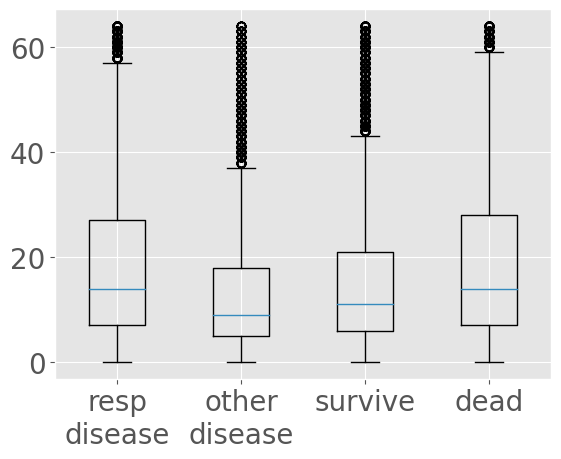

In [69]:
data_dict = {
    'resp\ndisease': ch2[ch2.is_resp]["hours"],
    'other\ndisease': ch2[ch2.is_resp == False]["hours"],
    'survive': ch2[ch2.is_dead == False]["hours"],
    'dead': ch2[ch2.is_dead]["hours"],
}

fig, ax = plt.subplots()
ax.boxplot(data_dict.values())
ax.set_xticklabels(data_dict.keys())

*The total hours of ventilator uses in roughly the same for patient with respiratory disease, other disease, survive, or dead*  
  
*Predicting the ventilation time, also can be interesting as there is no significant different for patient with respiratory disease, and other disease  
Also, there is no significant difference between the patient that survived and not*

hours start to use ventilator

[Text(1, 0, 'resp\ndisease'),
 Text(2, 0, 'other\ndisease'),
 Text(3, 0, 'survive'),
 Text(4, 0, 'dead')]

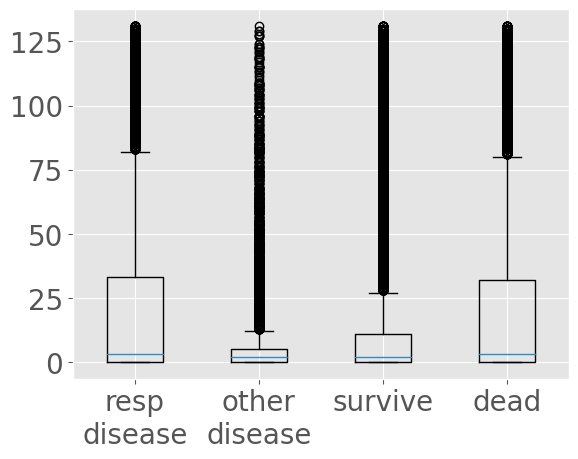

In [70]:
data_dict = {
    'resp\ndisease': ch2[ch2.is_resp]["hours_start"],
    'other\ndisease': ch2[ch2.is_resp == False]["hours_start"],
    'survive': ch2[ch2.is_dead == False]["hours_start"],
    'dead': ch2[ch2.is_dead]["hours_start"],
}

fig, ax = plt.subplots()
ax.boxplot(data_dict.values())
ax.set_xticklabels(data_dict.keys())

*Majority of patients, is already using ventilator when entering ICU (predicting when to use ventilator probably not that interesting)*

*Note: if we want to predict the need of ventilator, we should filter patient that comes in the ICU without ventilator (like filter hours start > 6)*

## Feature Engineering (TODO)

- vital signs
- labs